Ref: https://kgptalkie.com/text-generation-using-tensorflow-keras-and-lstm/

# Automatic Text Generation

Automatic text generation is the generation of natural language texts by computer. It has applications in automatic documentation systems, automatic letter writing, automatic report generation, etc. In this project, we are going to generate words given a set of input words. We are going to train the LSTM model using William Shakespeare's writings. The dataset is available [here](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt).

# LSTM


* Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory.
* Generally LSTM is composed of a cell (the memory part of the LSTM unit) and three "regulators", usually called gates, of the flow of information inside the LSTM unit: an input gate, an output gate and a forget gate.
* Intuitively, the cell is responsible for keeping track of the dependencies between the elements in the input sequence.
* The input gate controls the extent to which a new value flows into the cell, the forget gate controls the extent to which a value remains in the cell and the output gate controls the extent to which the value in the cell is used to compute the output activation of the LSTM unit.
* The activation function of the LSTM gates is often the logistic sigmoid function.
* There are connections into and out of the LSTM gates, a few of which are recurrent. The weights of these connections, which need to be learned during training, determine how the gates operate.

Here we are importing the necessary libraries:

* We have used a command to select the tensorflow version as 2.x
* We have imported `tensorflow` to build the model.
* We have imported `string` to get set of punctuations.
* We have imported `requests` to get the data file in the notebook.

In [73]:
import tensorflow as tf
import string 
import requests

In [74]:
# from google.colab import files
# uploaded = files.upload()

Next, you will lowercase and split the plain text into a list of sentences:

In [75]:
# Load the dataset
data = open('./search-keywords-cat.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Clean the dataset
for i in range(len(corpus)):
  corpus[i] = corpus[i].replace('\ufeff', '').replace('“','').replace('”','').replace('.','').replace('?','').replace('-','')


# Preview the result
print(corpus[0])

gejala dan pengobatan penyakit ginjal pada kucing


The total number of lines in our data is 1273.

In [76]:
len(corpus)

2127

Right now we have a list of the lines in the data. Now we are going to `join` all the lines and create a long string consisting of the data in continuous format.

In [77]:
corpus = " ".join(corpus)
corpus[:1000]

'gejala dan pengobatan penyakit ginjal pada kucing penyebab dan pengobatan diabetes kucing cara mengatasi masalah pernapasan pada kucing tandatanda dan pengobatan penyakit kulit pada kucing cara mengobati infeksi saluran kemih pada kucing penyebab dan pengobatan penyakit hati pada kucing cara merawat gigi kucing untuk mencegah penyakit gigi mengenal tandatanda dan pengobatan penyakit jantung pada kucing cara mengobati alergi pada kucing gejala dan pengobatan penyakit perut pada kucing cara mengatasi gangguan pencernaan pada kucing penyebab dan pengobatan penyakit mata pada kucing tandatanda dan pengobatan penyakit tulang dan sendi pada kucing mengatasi masalah kecemasan dan stres pada kucing penyebab dan pengobatan gangguan peredaran darah pada kucing cara mengobati masalah reproduksi pada kucing tandatanda dan pengobatan penyakit pernapasan kronis pada kucing mengatasi masalah kesehatan pada kucing yang lebih tua penyebab dan pengobatan gangguan sistem saraf pada kucing cara mengobati

You can see that the data consists of various punctuation marks. We are going to create a function `clean_text()` to remove all the punctuation marks and special characters from the data.

We will split the data according to space character and separate each word using `split()`.

`maketrans()` function is used to construct the transition table i.e specify the list of characters that need to be replaced in the whole string or the characters that need to be deleted from the string. The first parameter specifies the list of characters that need to be replaced, the second parameter specifies the list of characters with which the characters need to be replaced, the third parameter specifies the list of characters that needs to be deleted.It returns the translation table which specifies the conversions that can be used by `translate()`.

`string.punctuation` is a pre-initialized string used as string constant which will give all the sets of punctuation.

To translate the characters in the string `translate()` is used to make the translations. This function uses the translation mapping specified using the `maketrans()`.

The `isalpha()` method returns `True` if all the characters are alphabet letters (a-z). The `lower()` methods returns the lowercased string from the given string.

We can see that after passing `data` to `clean_text()` we get the data in the required format without punctuations and special characters.

In [78]:
def clean_text(doc):
  tokens = doc.split()
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens

tokens = clean_text(data)
print(tokens[:5])

['gejala', 'dan', 'pengobatan', 'penyakit', 'ginjal']


The total number of words are 13012.

In [79]:
len(tokens) 

21831

The total number of unique words are 1246.

In [80]:
len(set(tokens))

1578

As discussed before we are going to use a set of previous words to predict the next word in the sentence. To be precise we are going to use a set of 5 words to predict the 6st word. Hence we are going to divide our data in chunks of 51 words and at the last we will separate the last word from every line. We are going to limit our dataset to 200000 words.

In [81]:
length = 5 + 1
lines = []

for i in range(length, len(tokens)):
  seq = tokens[i-length:i]
  line = ' '.join(seq)
  lines.append(line)
  if i > 200000:
    break

print(len(lines))

21825


Now we will see the first line consisting of 6 words.

In [82]:
lines[0]

'gejala dan pengobatan penyakit ginjal pada'

The 6st word in this line is  which will the output word used for prediction.`'pada'`

In [83]:
tokens[6]

'kucing'

This is the second line consisting of 6 words. As you can see we have hopped by one word. The 51st word in this line is  which will the output word used for prediction.`'kucing'`

In [84]:
lines[1]

'dan pengobatan penyakit ginjal pada kucing'

# Build LSTM Model and Prepare and `X` `y`
Here we have imported all the necessary libraries used to pre-process the data and create the layers of the neural network.

In [85]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

We are going to create a unique numerical token for each unique word in the dataset.  updates internal vocabulary based on a list of texts.  transforms each text in texts to a sequence of integers.`fit_on_texts()` `texts_to_sequences()`

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token_new.pkl', 'wb'))
sequences = tokenizer.texts_to_sequences(lines)

`sequences` containes a list of integer values created by . Each line in  has 6 words. Now we will split each line such that the first 5 words are in  and the last word is in . `tokenizer` `sequences` 
 `X` `y`

In [87]:
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:,-1]
X[0]

array([202,   3,  85,  35, 129])

`vocab_size` contains all the uniques words in the dataset.  gives the mapping of each unique word to its numerical equivalent. Hence  of  gives the .`tokenizer.word_index` `len()` `tokenizer.word_index` `vocab_size`

In [88]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1579


`to_categorical()` converts a class vector (integers) to binary class matrix.  is the total number of classes which is .`num_classes` `vocab_size`

In [89]:
y = to_categorical(y, num_classes=vocab_size)

The length of each sequence in  is 5.`x`

In [90]:
seq_length = X.shape[1]
seq_length

5

# LSTM Model
A  is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.`Sequential model`

## Embedding layer
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. It requires 3 arguments:

* `input_dim`: This is the size of the vocabulary in the text data which is  in this case. `vocab_size`
* `output_dim`: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word.
`input_length`: Length of input sequences which is . `seq_length`

## LSTM layer:
This is the main layer of the model. It learns long-term dependencies between time steps in time series and sequence data.  when set to  returns the full sequence as the output. `return_sequence` `True`


## Dense layer:
Dense layer is the regular deeply connected neural network layer. It is the most common and frequently used layer. The rectified linear activation function or  for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. `relu`


The last layer is also a dense layer with 13009 neurons because we have to predict the probabilties of 13009 words. The activation function used is . Softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1. `softmax`

In [91]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=seq_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 32)             50528     
                                                                 
 lstm_6 (LSTM)               (None, 5, 64)             24832     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1579)              102635    
                                                                 
Total params: 215,179
Trainable params: 215,179
Non-trainable params: 0
_________________________________________________________________


In [93]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("next_words.h5", 
                             monitor='loss', 
                             verbose=2, 
                             save_best_only=True)

learning_rate = 0.001
model.compile(
    loss = 'categorical_crossentropy', 
    # optimizer = 'adam', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics = ['accuracy']
    )

After compiling the model we will now train the model using  on the training dataset. We will use 100  to train the model. An epoch is an iteration over the entire x and y data provided.  is the number of samples per gradient update i.e. the weights will be updates after 256 training examples. `model.fit()` `epochs` `batch_size`

In [94]:
history = model.fit(X, y, batch_size = 128, epochs = 100, verbose=2, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/100

Epoch 1: loss improved from inf to 5.81570, saving model to next_words.h5
154/154 - 10s - loss: 5.8157 - accuracy: 0.0822 - val_loss: 6.7980 - val_accuracy: 0.1310 - 10s/epoch - 62ms/step
Epoch 2/100

Epoch 2: loss improved from 5.81570 to 5.29997, saving model to next_words.h5
154/154 - 3s - loss: 5.3000 - accuracy: 0.0940 - val_loss: 7.0552 - val_accuracy: 0.1310 - 3s/epoch - 23ms/step
Epoch 3/100

Epoch 3: loss improved from 5.29997 to 5.26562, saving model to next_words.h5
154/154 - 3s - loss: 5.2656 - accuracy: 0.0940 - val_loss: 7.2152 - val_accuracy: 0.1310 - 3s/epoch - 22ms/step
Epoch 4/100

Epoch 4: loss improved from 5.26562 to 5.14765, saving model to next_words.h5
154/154 - 3s - loss: 5.1476 - accuracy: 0.0931 - val_loss: 7.4010 - val_accuracy: 0.1232 - 3s/epoch - 22ms/step
Epoch 5/100

Epoch 5: loss improved from 5.14765 to 4.82900, saving model to next_words.h5
154/154 - 4s - loss: 4.8290 - accuracy: 0.1051 - val_loss: 7.5129 - val_accuracy: 0.1113 - 4s/epoch

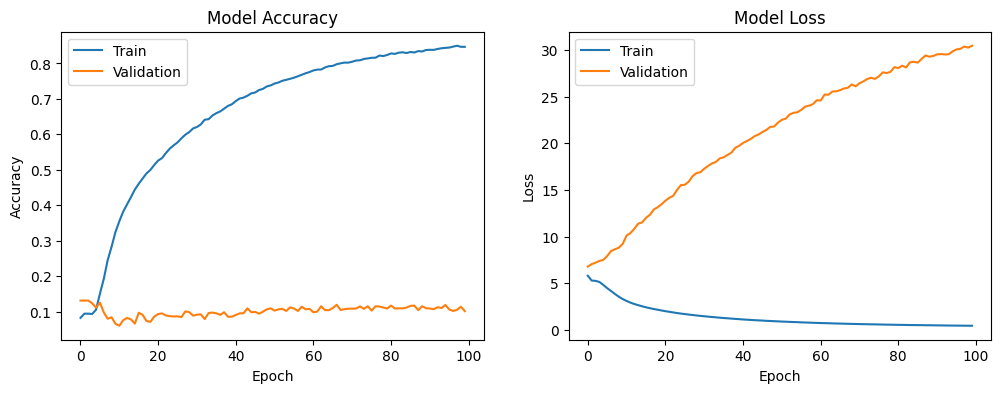

In [95]:
import matplotlib.pyplot as plt

# # Plot utility
# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.show()

# # Visualize the accuracy
# plot_graphs(history, "accuracy")
# plot_graphs(history, "val_acc")
# plot_graphs(history, "loss")
# plot_graphs(history, "val_loss")
# Plot the training progress
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.tight_layout()
plt.show()

We are now going to generate words using the model. For this we need a set of 5 words to predict the 51st word. So we are taking a random line.

In [96]:
# seed_text=lines[12343]
seed_text="bagaimana cara"
seed_text

'bagaimana cara'

`generate_text_seq()` generates  number of words after the given . We are going to pre-process the  before predicting. We are going to encode the  using the same encoding used for encoding the training data. Then we are going to convert the to 5 words by using . Now we will predict using . After that we will search the word in  using the index in . Finally we will append the predicted word to  and  and repeat the process. `n_words` `seed_text` `seed_text` `seed_text` `seed_text` `pad_sequences()` `model.predict_classes()` `tokenizer` `y_predict` `seed_text` `text`

In [97]:
def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
  text = []

  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating='pre')

    # y_predict = model.predict_classes(encoded)
    y_predict = np.argmax(model.predict(encoded), axis=1)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predict:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

We can see that the next 5 words are predicted by the model for the . `seed_text`

In [98]:
generate_text_seq(model, tokenizer, seq_length, "bagaimana cara", 5)

1/1 [==============================] - 0s 60ms/step


'mengatasi masalah kucing yang sering'

In [99]:
# model.save("text_generation_model(new).h5")